<a href="https://colab.research.google.com/github/Tharun-Prasad/track-my-food/blob/main/food_recipes_identification_using_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'recipes:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F326046%2F653875%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240823%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240823T113117Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D939a5594de8298d224c452d1fae2062f5be67e8985135d3750f3b24c7a20136e50a3860ed185101f17298faa842345235dbf9378fe21b9b99d1ca039378e75742a259950df400a299ddab3c146a783745cc6dba70c4fe37dbbd4380fcd895b229ae3ce9ab59a059743bc13ca8864605c93ce78f565853e7ccdc92291e82eb7fd3d931375bd8447eca65602b387b79683a16f1b87e5b7f2462f452cda9893c054491e3c89507f34080d161bc4ae4198dfb469ba03d2a39ab92ceeed74943adcd66dae4fc005ca11be8d02658544f1765648b1705eb47306846f3d49b311f32906073de4d9e4df8e0a61609432f6b764b37a89e5daf12cc58e0d899845ace7c598'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 165741129 bytes downloaded
Downloaded and uncompressed: recipes
Data source import complete.


In [ ]:


import numpy as np
import pandas as pd

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/recipes/pizza/image22.jpeg
/kaggle/input/recipes/pizza/5bff19e748eb124b3e421886-750-562.jpg
/kaggle/input/recipes/pizza/images1.jpg
/kaggle/input/recipes/pizza/https3A2F2Fstorage.googleapis.com2Fgen-atmedia2F32F20122F102F49857603ba4434ed65523956d5644f63a84d531f.jpeg
/kaggle/input/recipes/pizza/images.jpg
/kaggle/input/recipes/pizza/caprese-pizza-ck-x.jpg
/kaggle/input/recipes/pizza/3.jpg
/kaggle/input/recipes/pizza/image49.jpeg
/kaggle/input/recipes/pizza/image40.jpeg
/kaggle/input/recipes/pizza/homemade-pizza-horiz-a-1200.jpg
/kaggle/input/recipes/pizza/breakfast-pizza-1-8.jpg
/kaggle/input/recipes/pizza/fdd159bb-8f94-497e-9c55-7d9a8af42e50.jpg
/kaggle/input/recipes/pizza/image21.jpeg
/kaggle/input/recipes/pizza/image44.jpeg
/kaggle/input/recipes/pizza/low-carb-keto-friendly-pizza-145723-2.jpg
/kaggle/input/recipes/pizza/vrladtuf7sqepkuemogi.jpg
/kaggle/input/recipes/pizza/ls.jpg
/kaggle/input/recipes/pizza/image24.jpeg
/kaggle/input/recipes/pizza/1516849378820.jpg
/kagg

 Importing Various Modules.¶

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


In [ ]:

# sets matplotlib to inline and displays graphs below the corresponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image


In [ ]:
X=[]
Z=[]
IMG_SIZE=150
FOOD_BIRIYANI_DIR='../input/recipes/briyani'
FOOD_BURGER_DIR='../input/recipes/burger'
FOOD_DOSA_DIR='../input/recipes/dosa/'
FOOD_IDLY_DIR='../input/recipes/idly'
FOOD_PIZZA_DIR='../input/recipes/pizza/'

In [ ]:
def assign_label(img,food_type):
    return food_type

In [ ]:
def make_train_data(food_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,food_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

        X.append(np.array(img))
        Z.append(str(label))


In [ ]:
make_train_data('Biriyani',FOOD_BIRIYANI_DIR)
print(len(X))

100%|██████████| 166/166 [00:01<00:00, 97.52it/s] 

166


In [ ]:
make_train_data('Burger',FOOD_BURGER_DIR)
print(len(X))

100%|██████████| 147/147 [00:03<00:00, 41.82it/s]

313


In [ ]:
make_train_data('Dosa',FOOD_DOSA_DIR)
print(len(X))

100%|██████████| 148/148 [00:03<00:00, 37.67it/s]

461


In [ ]:
make_train_data('Idly',FOOD_IDLY_DIR)
print(len(X))

100%|██████████| 149/149 [00:01<00:00, 126.06it/s]

610


In [ ]:
make_train_data('Pizza',FOOD_PIZZA_DIR)
print(len(X))

100%|██████████| 155/155 [00:02<00:00, 75.85it/s] 

765


Visualizing some Random Images

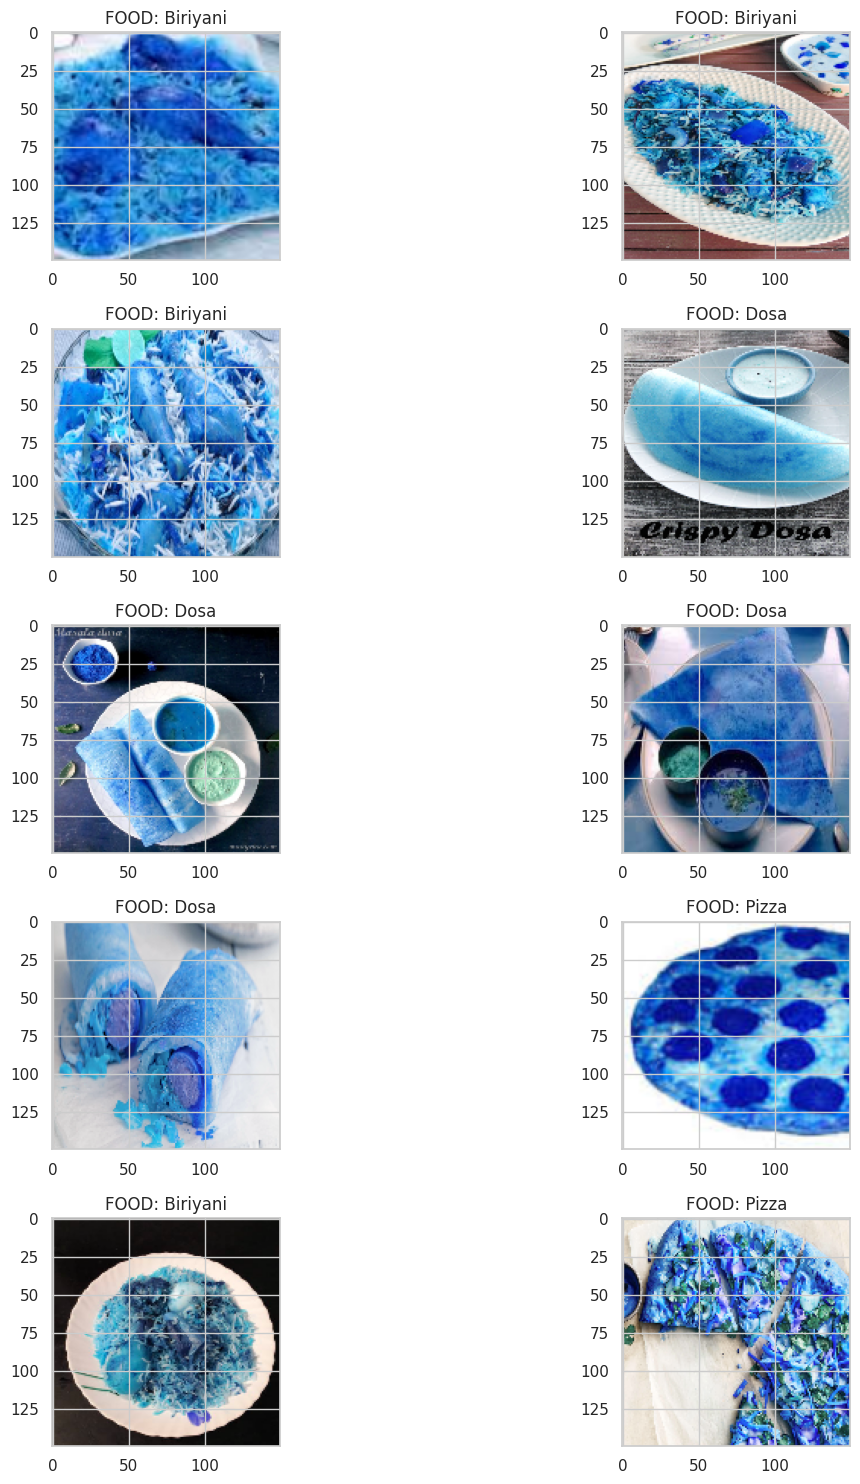

In [ ]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l], cmap="gray")
        ax[i,j].set_title('FOOD: '+Z[l])

plt.tight_layout()

Label Encoding the Y array

In [ ]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

Splitting into Training and Validation Sets¶

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

 Setting the Random Seeds

In [ ]:
np.random.seed(42)
rn.seed(42)


Building the Cnn Model

In [ ]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))




/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Using a LR Annealer¶

In [ ]:
batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

Data Augmentation to prevent Overfitting¶

In [ ]:
 datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images



In [ ]:
datagen.fit(x_train)

Compiling the Keras Model & Summary¶

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 96)          │          55,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 96)          │          83,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7776)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,981,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,143,749 (15.81 MB)

 Trainable params: 4,143,749 (15.81 MB)

 Non-trainable params: 0 (0.00 B)

Fitting on the Training set and making predcitons on the Validation set

In [ ]:
istory = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    epochs=5,
                    validation_data=(x_test, y_test),
                    verbose=1,
                    steps_per_epoch=x_train.shape[0] // batch_size)


Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 9s/step - accuracy: 0.5398 - loss: 1.1078 - val_accuracy: 0.6250 - val_loss: 0.8787
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.6230 - loss: 0.8810 - val_accuracy: 0.6302 - val_loss: 0.9266
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 36s 8s/step - accuracy: 0.6308 - loss: 0.9311 - val_accuracy: 0.6406 - val_loss: 0.9313
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 984ms/step - accuracy: 0.6172 - loss: 1.0715 - val_accuracy: 0.5781 - val_loss: 0.9898
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 7s/step - accuracy: 0.6104 - loss: 0.9866 - val_accuracy: 0.7344 - val_loss: 0.7968


In [ ]:
model.save('my_model.keras')

Evaluating the Model Performance

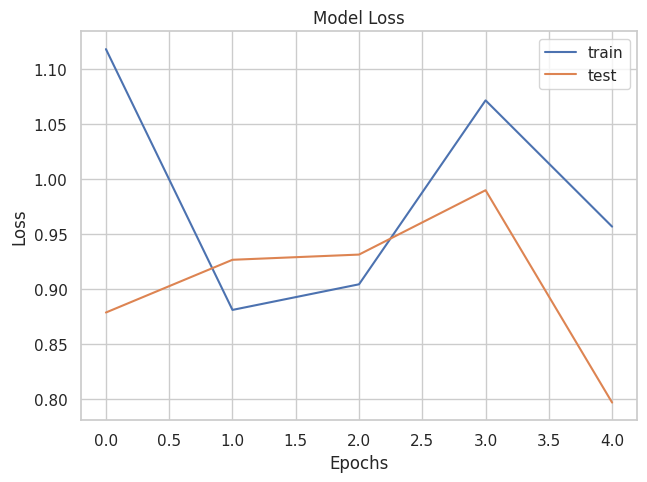

In [ ]:
plt.plot(istory.history['loss'])
plt.plot(istory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()


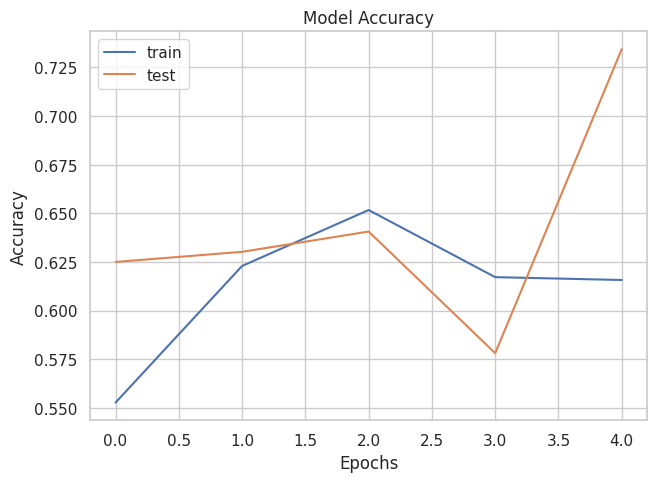

In [ ]:
plt.plot(istory.history['accuracy'])
plt.plot(istory.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

Visualizing Predictons on the Validation Set

In [ ]:
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 488ms/step


In [ ]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

CORRECTLY CLASSIFIED FLOWER IMAGES¶

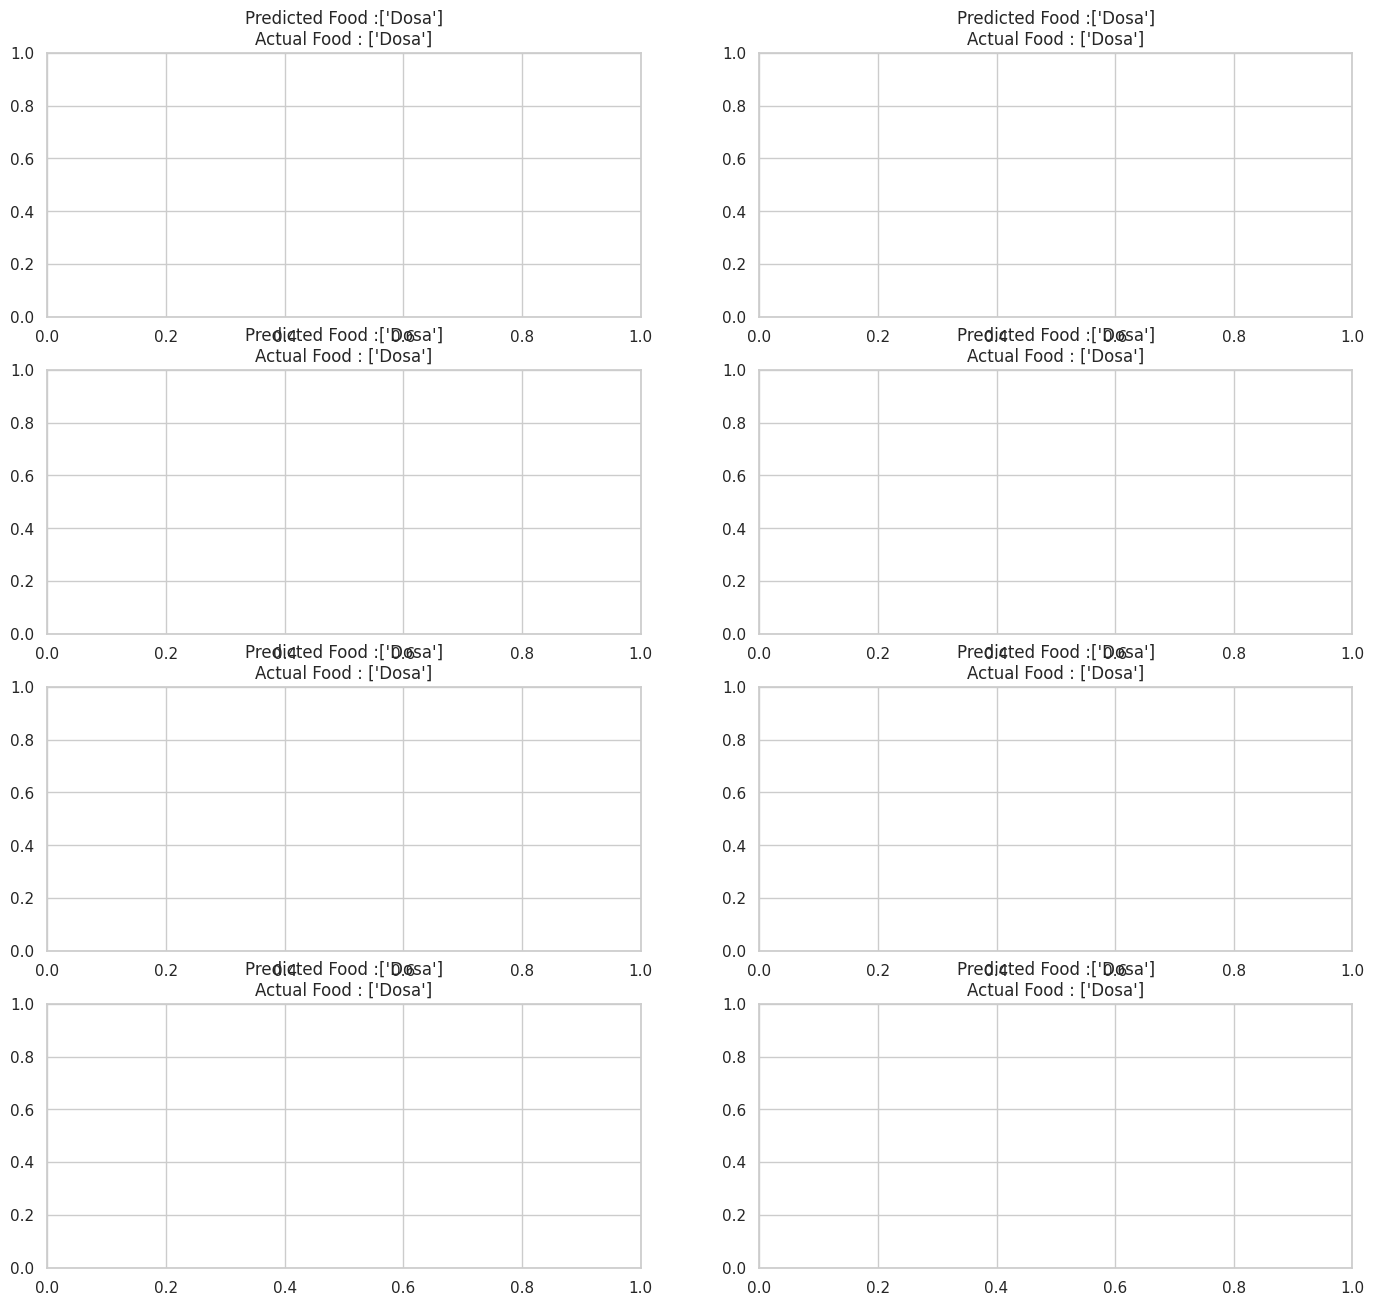

In [ ]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].set_title("Predicted Food :"+str(le.inverse_transform([pred_digits[prop_class[count]]]))
                          +"\n"+"Actual Food : "+str(le.inverse_transform([np.argmax(y_test[prop_class[count]])])))